# Importing dependencies

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import DMatrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
from pathlib import Path
import pickle
import joblib
import gradio as gr
import huggingface_hub

# Importing data and handling it

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)

In [8]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')
display(df.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [10]:
numerical_cols = ['tenure','MonthlyCharges','TotalCharges']

for col in df.columns:
  if col not in numerical_cols:
    print(f'{col} : {df[col].unique()}')

customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender : ['Female' 'Male']
SeniorCitizen : [0 1]
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn : ['No' 'Yes']


In [11]:
df=df.drop(columns=['customerID'],axis=1)

In [12]:
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [13]:
len(df[df['TotalCharges']==' '])

11

In [14]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df['TotalCharges'].median())


In [15]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [17]:
df['Churn'].value_counts()

,count
Churn,
No,5174
Yes,1869


In [18]:
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})

/tmp/ipython-input-18-2364848822.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})


1. CustomerId coloumn removed
2. totalcharges whitespaces replaced with Nan and changed to float
3. imbalanced target coloumn revealed and mapping [True:1] [false:0]

# Exploratory data analysis

In [19]:
def plot_histogram(df,coloumn_name):
    plt.figure(figsize=(6,3))
    sns.histplot(df[coloumn_name],kde=True)
    plt.title(f'Distribution of {coloumn_name}')

    #calc mean and median values
    col_mean=df[coloumn_name].mean()
    col_median=df[coloumn_name].median()

    #plotting mean and median lines
    plt.axvline(col_mean,color='red',linestyle='--',label='Mean')
    plt.axvline(col_median,color='blue',linestyle='-',label='Median')

    plt.legend()
    plt.show

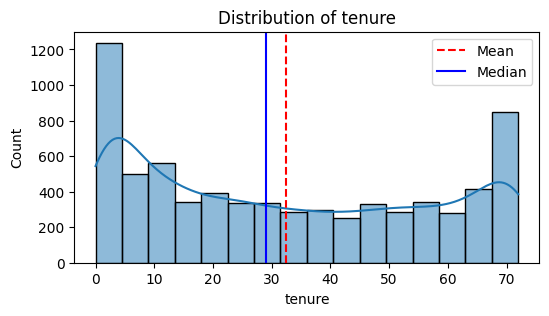

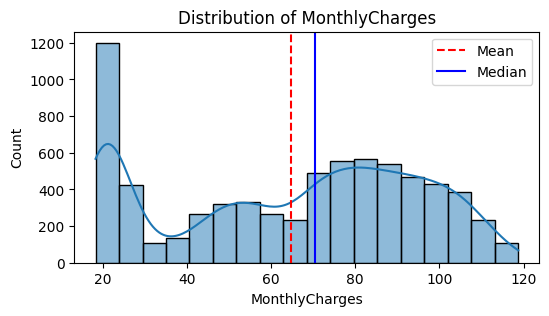

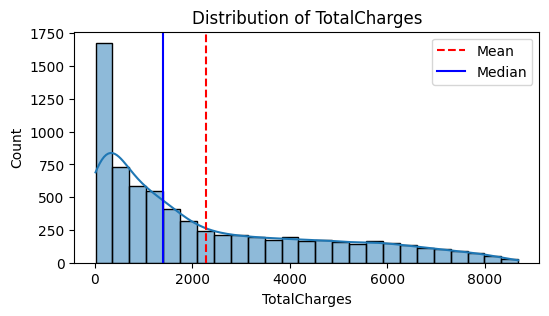

In [20]:
#Distribution of nummerical coloumns
plot_histogram(df,'tenure')
plot_histogram(df,'MonthlyCharges')
plot_histogram(df,'TotalCharges')

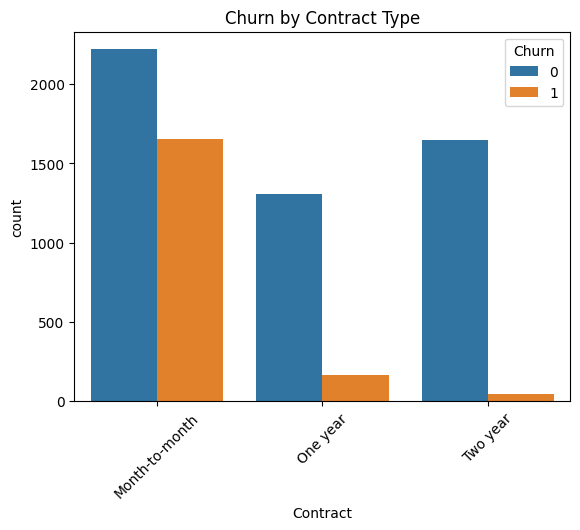

In [21]:
# Churn by Contract Type
sns.countplot(x="Contract", hue="Churn", data=df)
plt.title("Churn by Contract Type")
plt.xticks(rotation=45)
plt.show()

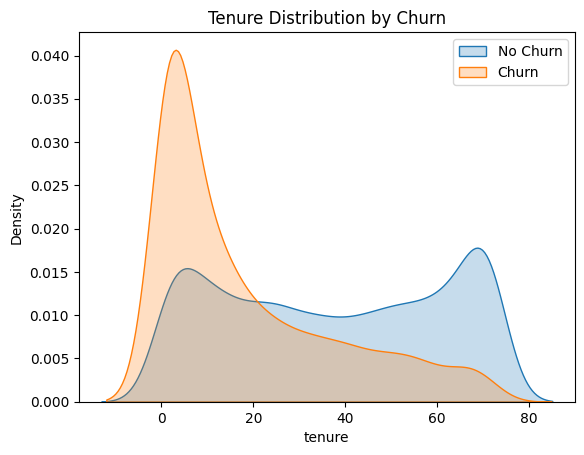

In [22]:
# Monthly vs Total Charges colored by Churn
sns.kdeplot(data=df[df["Churn"] == 0]["tenure"], label="No Churn", fill=True)
sns.kdeplot(data=df[df["Churn"] == 1]["tenure"], label="Churn", fill=True)
plt.title("Tenure Distribution by Churn")
plt.legend()
plt.show()

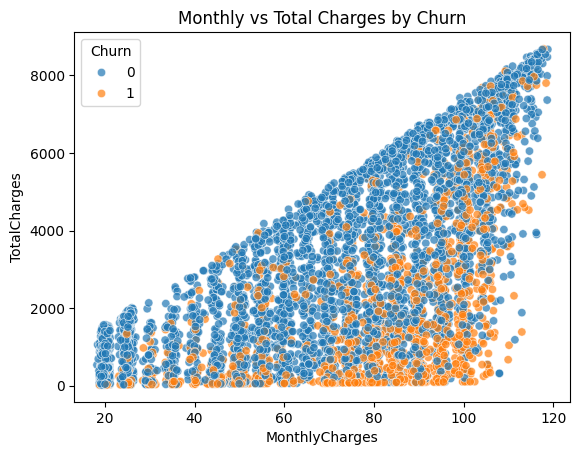

In [23]:
sns.scatterplot(data=df, x="MonthlyCharges", y="TotalCharges", hue="Churn", alpha=0.7)
plt.title("Monthly vs Total Charges by Churn")
plt.show()

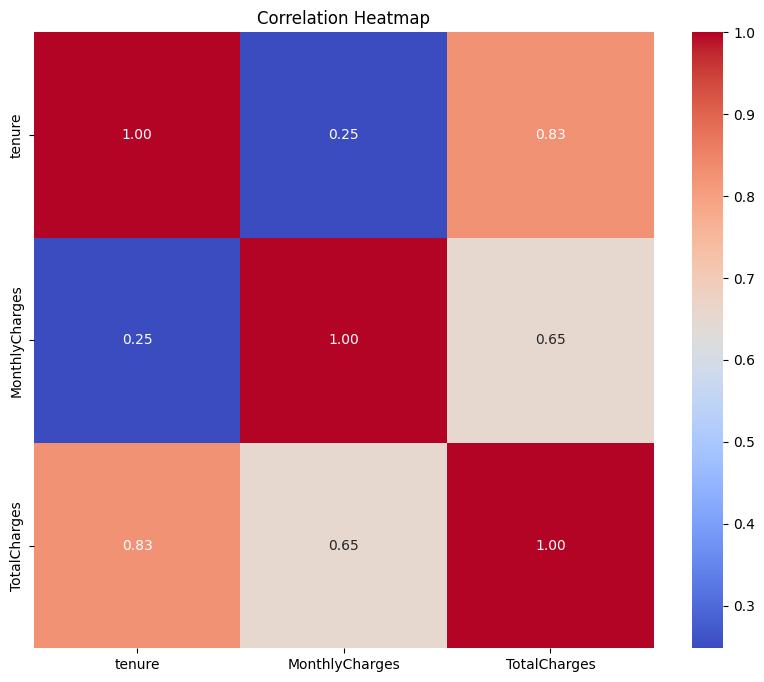

In [24]:
#correlation heat-map
plt.figure(figsize=(10,8))
sns.heatmap(df[['tenure','MonthlyCharges','TotalCharges']].corr(),annot=True,cmap='coolwarm',fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Data preprocessing

In [25]:
X=df.drop('Churn',axis=1)
Y=df['Churn']

Countplot for categorical coloumns

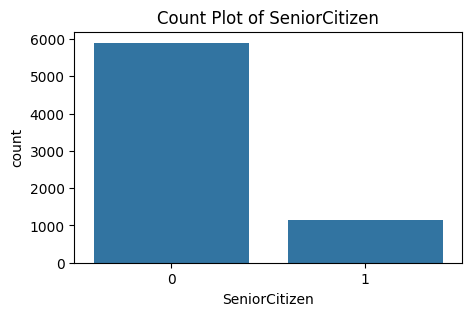

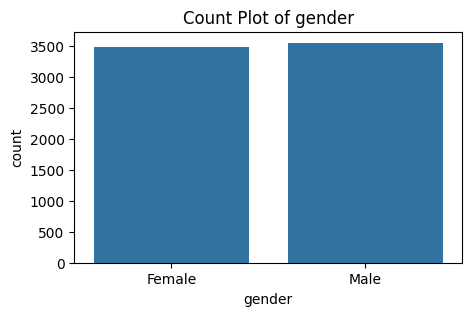

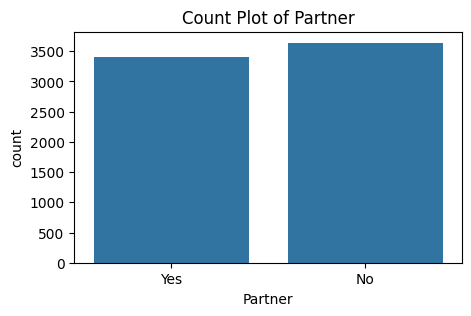

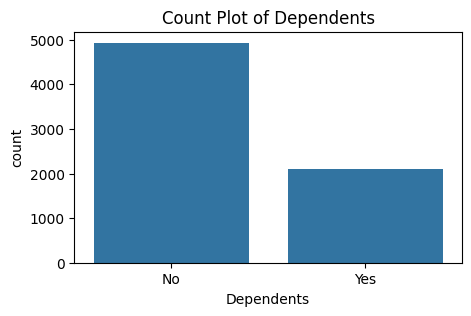

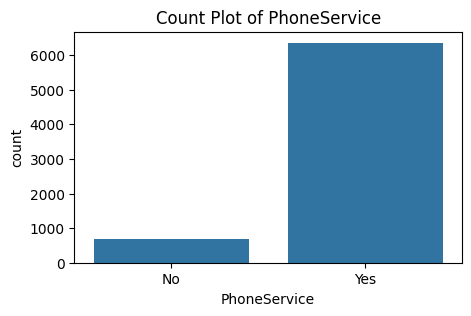

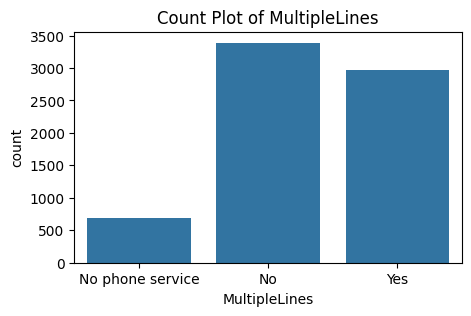

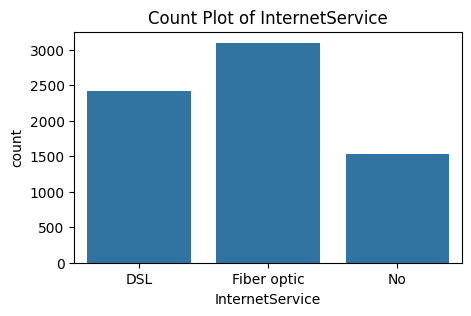

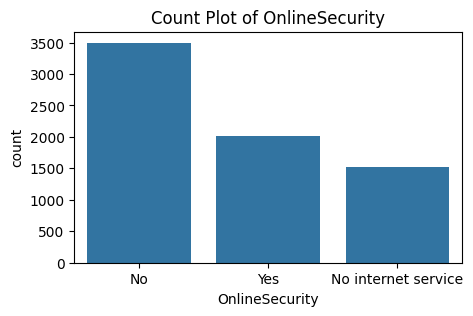

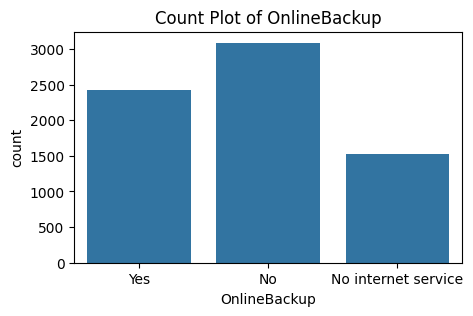

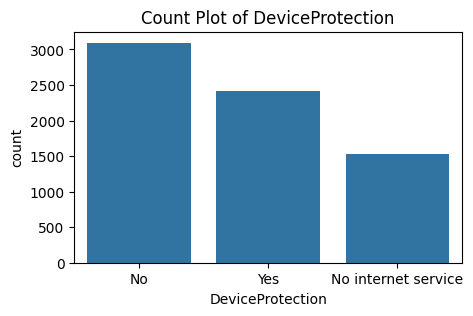

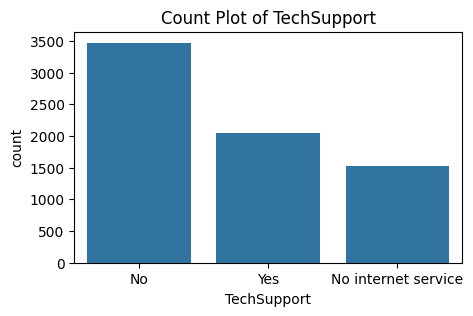

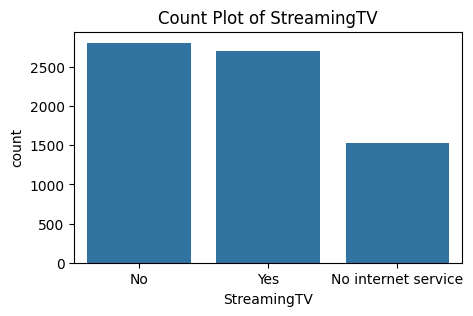

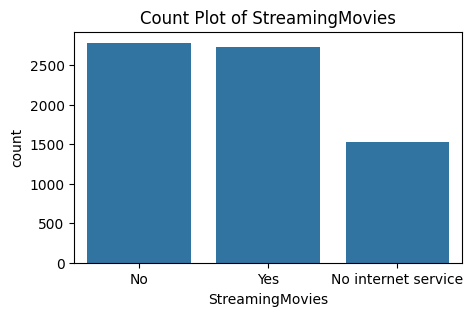

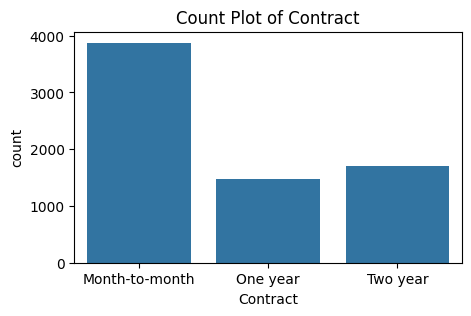

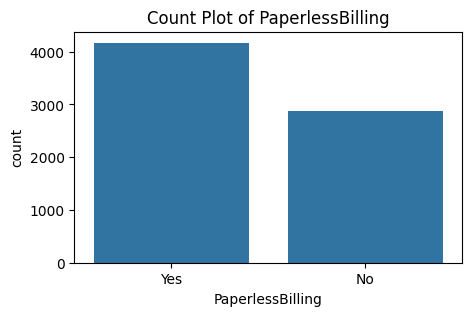

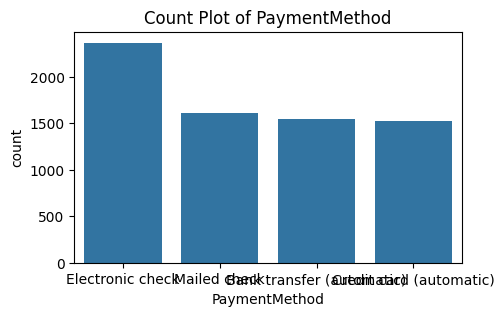

In [26]:
object_cols = X.select_dtypes(include="object").columns.to_list()

object_cols = ["SeniorCitizen"] + object_cols

for col in object_cols:
  plt.figure(figsize=(5, 3))
  sns.countplot(x=df[col])
  plt.title(f"Count Plot of {col}")
  plt.show()

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


OneHot encoding for categorical coloumns


In [28]:
print(object_cols)

['SeniorCitizen', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [29]:
num_cols = [col for col in X.columns if col not in object_cols]


In [30]:
categorical_pipeline= Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))
])
preprocessor_pipeline=ColumnTransformer([
    ('cat',categorical_pipeline,object_cols)
],remainder='passthrough')

In [31]:
X_preprocessed=preprocessor_pipeline.fit_transform(X)

In [32]:
final_cols=object_cols+num_cols
df_encoded=pd.DataFrame(X_preprocessed,columns=final_cols)
df_encoded.head()

,SeniorCitizen,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,tenure,MonthlyCharges,TotalCharges
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,29.85,29.85
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,34.0,56.95,1889.50
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,53.85,108.15
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,45.0,42.30,1840.75
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,70.70,151.65


# **Training and splitting data**

In [33]:
X_temp,X_test,Y_temp,Y_test=train_test_split(X_preprocessed,Y,test_size=0.2,random_state=22)
X_train,X_val,Y_train,Y_val=train_test_split(X_temp,Y_temp,test_size=0.25,random_state=22)
Y_train.value_counts()

,count
Churn,
0,3135
1,1090


Synthetic Minority Oversampling TEchnique (SMOTE) to handle imbalanced target column

In [34]:
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

In [35]:
Y_train_resampled.value_counts()

,count
Churn,
0,3135
1,3135


# Modelling

In [36]:
# dictionary of models
models = { "Random Forest": RandomForestClassifier(),
           "Decision Tree": DecisionTreeClassifier(),
           "XGBoost": XGBClassifier(),
           "Logistic Regression": LogisticRegression(),
           "K-Nearest Neighbors": KNeighborsClassifier()
          }


In [37]:
# dictionary to store the cross validation results
cv_scores = {}
for model_name,model in models.items():
 print(f"training model{model_name}")
 scores= cross_val_score(model,X_train_resampled,Y_train_resampled,cv=5,scoring='accuracy')
 cv_scores[model_name] = scores
 print(f"{model_name}with baseline parameters accuracy: {scores.mean()*100:.2f}")

training modelRandom Forest
Random Forestwith baseline parameters accuracy: 85.31
training modelDecision Tree
Decision Treewith baseline parameters accuracy: 81.12
training modelXGBoost
XGBoostwith baseline parameters accuracy: 84.48
training modelLogistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regressionwith baseline parameters accuracy: 77.32
training modelK-Nearest Neighbors
K-Nearest Neighborswith baseline parameters accuracy: 78.23


In [38]:
# dictionary to store the cross validation results without handling imbalanced target column
cv_scores = {}
for model_name,model in models.items():
 print(f"training model{model_name}")
 scores= cross_val_score(model,X_train,Y_train,cv=5,scoring='accuracy')
 cv_scores[model_name] = scores
 print(f"{model_name}with baseline parameters accuracy: {scores.mean()*100:.2f}")

training modelRandom Forest
Random Forestwith baseline parameters accuracy: 79.76
training modelDecision Tree
Decision Treewith baseline parameters accuracy: 74.79
training modelXGBoost
XGBoostwith baseline parameters accuracy: 79.17
training modelLogistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regressionwith baseline parameters accuracy: 80.88
training modelK-Nearest Neighbors
K-Nearest Neighborswith baseline parameters accuracy: 78.08


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


by witnessing accuracy score for the used baseline models we see that the XGBoostclassifier with the imbalanced data handled is more accurate than the others then randomforestclassifier comes next


In [39]:
xgb= XGBClassifier(random_state=42)
xgb.fit(X_train_resampled,Y_train_resampled)
rfc= RandomForestClassifier(random_state=42)
rfc.fit(X_train_resampled,Y_train_resampled)


RandomForestClassifier(random_state=42)

In [40]:
y_preds_xgb= xgb.predict(X_val)

print("Accuracy score of xgb:\n",accuracy_score(Y_val,y_preds_xgb))
print("Confusion matrix of xgb:\n",confusion_matrix(Y_val,y_preds_xgb))
print("Classification report of xgb:\n",classification_report(Y_val,y_preds_xgb))

Accuracy score of xgb:
 0.7885024840312278
Confusion matrix of xgb:
 [[909 118]
 [180 202]]
Classification report of xgb:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1027
           1       0.63      0.53      0.58       382

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.78      1409



In [41]:
y_preds_rfc= rfc.predict(X_val)

print("Accuracy score of rfc:\n",accuracy_score(Y_val,y_preds_rfc))
print("Confusion matrix of rfc:\n",confusion_matrix(Y_val,y_preds_rfc))
print("Classification report of rfc:\n",classification_report(Y_val,y_preds_rfc))

Accuracy score of rfc:
 0.7814052519517388
Confusion matrix of rfc:
 [[910 117]
 [191 191]]
Classification report of rfc:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1027
           1       0.62      0.50      0.55       382

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



# Hyperparameter tuning of models (XGBoost,RandomForest)classifiers

In [42]:
rf_grid = {"n_estimators":np.arange(100,1000,50),
           "max_depth":[None,3,5,10],
           "min_samples_split":np.arange(2,20,2),
           "min_samples_leaf":np.arange(1,20,2)
}
xgb_grid =  {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

In [43]:
np.random.seed(42)
rs_rf=RandomizedSearchCV(rfc,param_distributions=rf_grid,cv=5,n_iter=20,verbose=True)
rs_rf.fit(X_train_resampled,Y_train_resampled)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700,
       750, 800, 850, 900, 950])},
                   verbose=True)

In [44]:
np.random.seed(42)
rs_xgb=RandomizedSearchCV(xgb,param_distributions=xgb_grid,cv=5,n_iter=20,verbose=True)
rs_xgb.fit(X_train_resampled,Y_train_resampled)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.05, 0.1],
                                        'max_depth': [3, 6],
                                        'n_estimators': [100, 200],
                                        'subsample': [0.8, 1.0]},
                   verbose=True)

In [45]:
rs_xgb.best_params_


{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.05}

In [46]:
rs_rf.best_params_

{'n_estimators': np.int64(300),
 'min_samples_split': np.int64(16),
 'min_samples_leaf': np.int64(1),
 'max_depth': None}

In [47]:
y_xgb_final_preds= rs_xgb.predict(X_test)
accuracy_xgb=accuracy_score(Y_test,y_xgb_final_preds)
conf_matrix_xgb=confusion_matrix(Y_test,y_xgb_final_preds)
class_report_xgb=classification_report(Y_test,y_xgb_final_preds)
f1_xgb=f1_score(Y_test,y_xgb_final_preds)
print("Accuracy score of xgb:\n",accuracy_xgb)
print("Confusion matrix of xgb:\n",conf_matrix_xgb)
print("Classification report of xgb:\n",class_report_xgb)
print("f1_score of xgb:\n",f1_xgb)

Accuracy score of xgb:
 0.7835344215755855
Confusion matrix of xgb:
 [[882 130]
 [175 222]]
Classification report of xgb:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1012
           1       0.63      0.56      0.59       397

    accuracy                           0.78      1409
   macro avg       0.73      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409

f1_score of xgb:
 0.5927903871829105


In [48]:
y_rfc_final_preds= rs_rf.predict(X_test)
accuracy_rfc=accuracy_score(Y_test,y_rfc_final_preds)
conf_matrix_rfc=confusion_matrix(Y_test,y_rfc_final_preds)
class_report_rfc=classification_report(Y_test,y_rfc_final_preds)
f1_rfc=f1_score(Y_test,y_rfc_final_preds)
print("Accuracy score of rfc:\n",accuracy_rfc)
print("Confusion matrix of rfc:\n",conf_matrix_rfc)
print("Classification report of rfc:\n",class_report_rfc)
print("f1_score of rfc:\n",f1_rfc)

Accuracy score of rfc:
 0.7806955287437899
Confusion matrix of rfc:
 [[896 116]
 [193 204]]
Classification report of rfc:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85      1012
           1       0.64      0.51      0.57       397

    accuracy                           0.78      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.77      0.78      0.77      1409

f1_score of rfc:
 0.5690376569037657


we see that after analyzing the two models performance the xgb tuned model is more reliable than that of randomforestclassifier and we will use for our app

# Model comparison


In [49]:
rs_xgb_model=rs_xgb.best_estimator_
rs_rf_model=rs_rf.best_estimator_

In [50]:
comparison_df= pd.DataFrame({
    'Accuracy':[accuracy_xgb,accuracy_rfc],
    'Confusion Matrix':[conf_matrix_xgb,conf_matrix_rfc],
    'Classification Report':[class_report_xgb,class_report_rfc],
    'f1_score':[f1_xgb,f1_rfc]


},index=['rs_xgb','rs_rf'])
comparison_df

,Accuracy,Confusion Matrix,Classification Report,f1_score
rs_xgb,0.783534,"[[882, 130], [175, 222]]",precision recall f1-score support\n\n 0 0.83 0.87 0.85 1012\n 1 0.63 0.56 0.59 397\n\n accuracy 0.78 1409\n macro avg 0.73 0.72 0.72 1409\nweighted avg 0.78 0.78 0.78 1409\n,0.592790
rs_rf,0.780696,"[[896, 116], [193, 204]]",precision recall f1-score support\n\n 0 0.82 0.89 0.85 1012\n 1 0.64 0.51 0.57 397\n\n accuracy 0.78 1409\n macro avg 0.73 0.70 0.71 1409\nweighted avg 0.77 0.78 0.77 1409\n,0.569038


visualizing Accuracy and f1_score of the tuned models


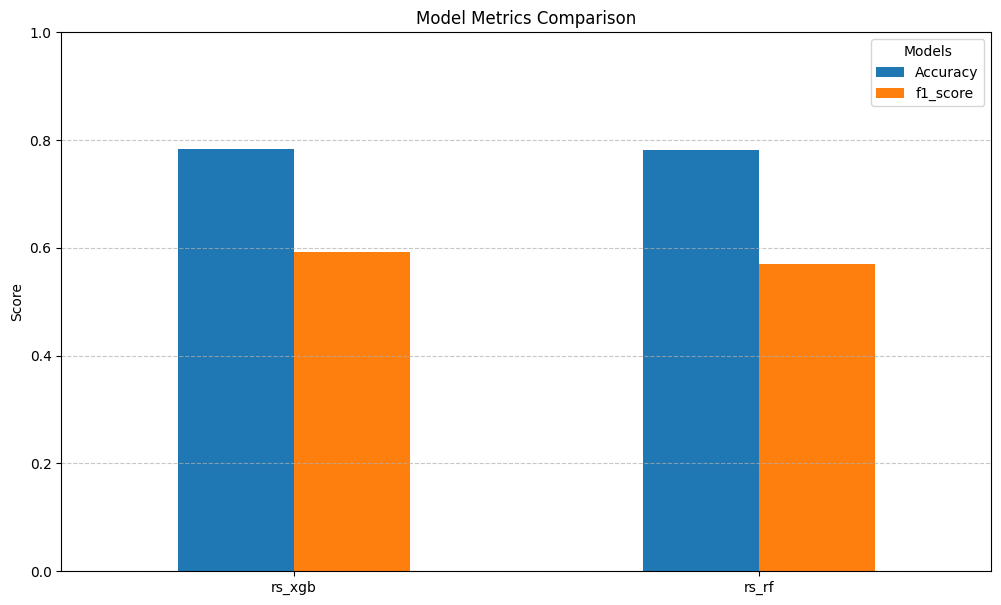

In [51]:
ax = comparison_df.plot(kind='bar', figsize=(12, 7))
plt.title('Model Metrics Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Models')
plt.grid(axis='y', linestyle='--', alpha=0.7)


8.Feature importance

In [52]:
feature_names = X.columns.tolist()
feature_importances_xgb = rs_xgb.best_estimator_.feature_importances_
feature_importances_rfc = rs_rf.best_estimator_.feature_importances_

In [53]:
feat_imp_xgb_df=pd.DataFrame({'Feature':feature_names,'Importance':feature_importances_xgb}).sort_values(by='Importance',ascending=False)
feat_imp_rfc_df=pd.DataFrame({'Feature':feature_names,'Importance':feature_importances_rfc}).sort_values(by='Importance',ascending=False)

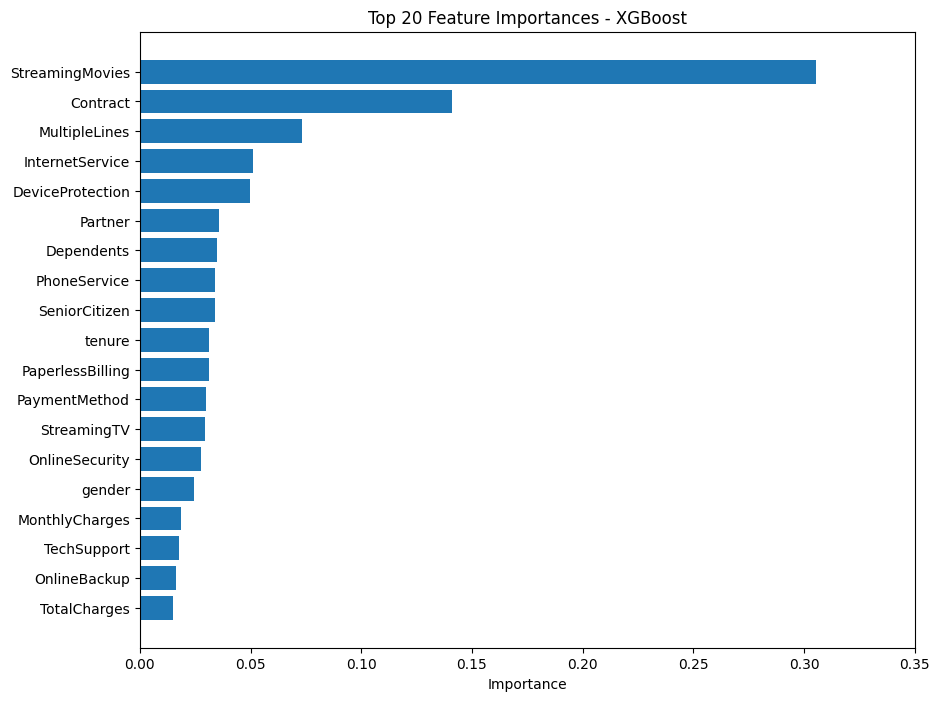

In [54]:
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_xgb_df['Feature'][:20][::-1], feat_imp_xgb_df['Importance'][:20][::-1])
plt.title('Top 20 Feature Importances - XGBoost')
plt.xlabel('Importance')
plt.xlim(0,0.35)
plt.show()

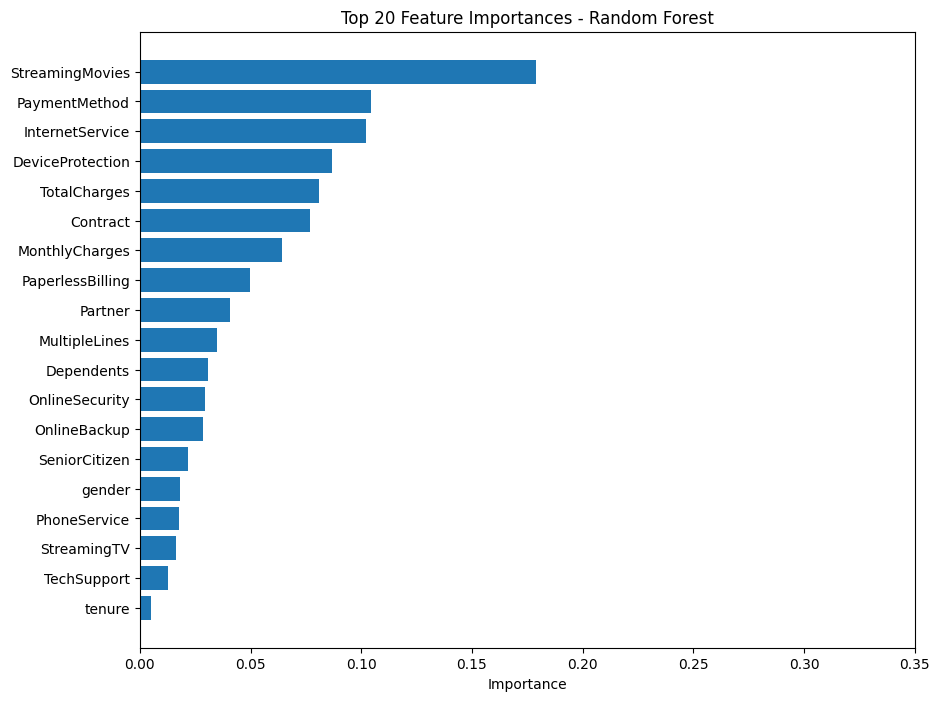

In [55]:
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_rfc_df['Feature'][:20][::-1], feat_imp_rfc_df['Importance'][:20][::-1])
plt.title('Top 20 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.xlim(0,0.35)
plt.show()

# Saving Model

In [56]:
models_folder = Path('/content/ML-Comp')
models_folder.mkdir(parents=True, exist_ok=True)


In [58]:
model_data1= {"model":rs_xgb_model,"preprocessor":preprocessor_pipeline}
file_name_model=models_folder / 'Customer_churn_model(XGB).pkl'
joblib.dump(model_data1,file_name_model)

['/content/ML-Comp/Customer_churn_model(XGB).pkl']

In [59]:
joblib.dump(rs_rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [60]:
model_data2= {"model":rs_rf_model,"preprocessor":preprocessor_pipeline}
file_name_model=models_folder / 'Customer_churn_model(RF).pkl'
joblib.dump(model_data2,file_name_model)

['/content/ML-Comp/Customer_churn_model(RF).pkl']

# Select features model

In [61]:
top_5_features = ['StreamingMovies', 'Contract', 'MultipleLines', 'InternetService', 'DeviceProtection']


In [62]:
X_selected= X[top_5_features]

In [63]:
selected_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [64]:
selected_preprocessor= ColumnTransformer([
    ('cat', selected_cat_pipeline, top_5_features)
], remainder='passthrough')

In [65]:
selected_model_pipeline= Pipeline([
    ('preprocessor', selected_preprocessor),
    ('model', rs_xgb_model)
])

In [103]:
# Initial split
X_trainval, X_selected_test, y_trainval, y_selected_test = train_test_split(
    X[top_5_features], Y, test_size=0.2, random_state=42)

# Optional: split validation manually if not using CV inside RS
X_selected_train, X_selected_val, y_selected_train, y_selected_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42)


In [104]:
X_selected_train.head()

,StreamingMovies,Contract,MultipleLines,InternetService,DeviceProtection
4806,No internet service,One year,No,No,No internet service
3409,Yes,Two year,Yes,Fiber optic,Yes
3339,Yes,Two year,Yes,DSL,Yes
3541,No,Month-to-month,No phone service,DSL,No
4009,Yes,Two year,No,DSL,Yes


In [105]:
y_selected_train.head()

,Churn
4806,0
3409,0
3339,0
3541,0
4009,0


In [106]:
X_selected_val.head()

,StreamingMovies,Contract,MultipleLines,InternetService,DeviceProtection
3575,Yes,Month-to-month,No phone service,DSL,No
4958,No,Month-to-month,Yes,Fiber optic,No
1447,No,Month-to-month,Yes,Fiber optic,No
3334,Yes,Month-to-month,Yes,Fiber optic,Yes
4041,Yes,Two year,No phone service,DSL,Yes


In [107]:
X_selected_test.shape, y_selected_test.shape, X_selected_train.shape, y_selected_train.shape, X_selected_val.shape, y_selected_val.shape

((1409, 5), (1409,), (4507, 5), (4507,), (1127, 5), (1127,))

In [108]:
selected_model_pipeline.fit(X_selected_train, y_selected_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['StreamingMovies',
                                                   'Contract', 'MultipleLines',
                                                   'InternetService',
                                                   'DeviceProtection'])])),
                ('model',
                 XGBClass...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [110]:
y_pred_sel = selected_model_pipeline.predict(X_selected_val)
print("Accuracy:", accuracy_score(y_selected_val, y_pred_sel))
print("F1 Score:", f1_score(y_selected_val, y_pred_sel))
print("Classification Report:\n", classification_report(y_selected_val, y_pred_sel))

Accuracy: 0.7675244010647737
F1 Score: 0.5647840531561462
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.84       822
           1       0.57      0.56      0.56       305

    accuracy                           0.77      1127
   macro avg       0.70      0.70      0.70      1127
weighted avg       0.77      0.77      0.77      1127



In [111]:
selected_preds = selected_model_pipeline.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, selected_preds))

Accuracy: 0.5947480482611781


In [116]:
model_data3= {"model":selected_model_pipeline}
file_name_model=models_folder / 'Selected_customer_churn_model.pkl'
joblib.dump(model_data3,file_name_model)

['/content/ML-Comp/Selected_customer_churn_model.pkl']

# Model Deployment

In [117]:
loaded_data = joblib.load(models_folder/"Selected_customer_churn_model.pkl")
model = loaded_data["model"]


In [121]:
def predict_churn(StreamingMovies, Contract, MultipleLines, InternetService, DeviceProtection):
    import pandas as pd

    try:
        # Build input dataframe from UI values
        input_df = pd.DataFrame([{
            'StreamingMovies': StreamingMovies,
            'Contract': Contract,
            'MultipleLines': MultipleLines,
            'InternetService': InternetService,
            'DeviceProtection': DeviceProtection
        }])

        prob = model.predict_proba(input_df)[0][1]
        pred = model.predict(input_df)[0]

        return f"Prediction: {'Churn' if pred == 1 else 'No Churn'} (Probability: {prob:.2f})"

    except Exception as e:
        return f"⚠️ Error: {str(e)}"


In [122]:
inputs = [
    gr.Radio(["No", "Yes"], label="StreamingMovies"),
    gr.Radio(["Month-to-month", "One year", "Two year"], label="Contract"),
    gr.Radio(["No", "Yes", "No phone service"], label="MultipleLines"),
    gr.Radio(["DSL", "Fiber optic", "No"], label="InternetService"),
    gr.Radio(["No", "Yes", "No internet service"], label="DeviceProtection")
]

output = gr.Textbox(label="Churn Prediction")

app = gr.Interface(
    fn=predict_churn,
    inputs=inputs,
    outputs=output,
    title="Customer Churn Prediction",
    description="Enter customer service details to predict churn probability."
)

app.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d53c807c1c4c3c8120.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
